In [1]:
import pandas as pd
import numpy as np
import os 


def CalulateResiduals(hdf):
    df = pd.read_hdf(hdf, key='df')
    needed_variables = ['jet_pt_area_corrected', 'jet_pt_multiplicity_corrected', 'jet_pt_dnn_corrected',
                    'jet_pt_snn_corrected', 'jet_pt_truth', 'jet_nparts', 'median_pt_over_npart', 'jet_pt_raw','jet_nparts_pythia']
    df = df[needed_variables].copy()
    
    df['nparts_difference'] = df['jet_nparts'] - df['jet_nparts_pythia']
    df['nparts_correction'] = df['median_pt_over_npart']*df['nparts_difference'] 
    df['jet_pt_nparts_corrected'] = df['jet_pt_raw'] - df['nparts_correction']
    
    jet_pt_variables = ['jet_pt_area_corrected', 'jet_pt_multiplicity_corrected', 'jet_pt_dnn_corrected', 'jet_pt_snn_corrected', 'jet_pt_nparts_corrected', 'jet_pt_truth', 'jet_pt_raw']
    df = df[jet_pt_variables].copy()
    
    pt_residuals = ['area_residual', 'multiplicity_residual', 'dnn_residual', 'snn_residual', 'nparts_residual']
    pt_corrections = ['jet_pt_area_corrected', 'jet_pt_multiplicity_corrected', 'jet_pt_dnn_corrected', 'jet_pt_snn_corrected', 'jet_pt_nparts_corrected']
    
    for residual, correction in zip(pt_residuals, pt_corrections):
        df[residual] = df[correction] - df['jet_pt_truth']
        
    return df
  
def BinJetData(hdf):
    '''
    Checks the max and min of the truth jet pt then creates bins every 10 GeV unless there is fewer than 10 jets in the bin, then it will merge the bin with the next bin
    '''
    df = pd.read_hdf(hdf, key='df')
    max = df['jet_pt_truth'].max()
    min = df['jet_pt_truth'].min()

    # make max and min in 10 GeV increments
    max = max + (10 - max % 10)
    min = min - (min % 10)
    
    if max > 200:
        max = 200

    # original bins
    proposed_bins = np.arange(min, max+10, 10)
    
    # get the number of jets in each bin
    jet_counts, bins = np.histogram(df['jet_pt_truth'], bins=proposed_bins, range=(min, max))

    new_bins = [bins[0]]
    counts = []
    total_jets = np.sum(jet_counts)
    
    for i in range(len(jet_counts)-1):
        if jet_counts[i] > 10000:
            new_bins.append(bins[i+1])
            counts.append(jet_counts[i])
        else:
            jet_counts[i+1] = jet_counts[i+1] + jet_counts[i]
            jet_counts[i] = 0
            
    if jet_counts[-1] > 10000:
        counts.append(jet_counts[-1])
        new_bins.append(bins[-1])
    else:
        counts[-1] += jet_counts[-1]
        new_bins[-1] = bins[-1]

    end_bin = 0
    for i in range(len(counts)-1):
        if counts[i+1] > counts[i]:
            end_bin = i
            break
    
    if end_bin !=0:
        new_bins = new_bins[:end_bin+1]
        counts = counts[:end_bin] 
    
    
    new_total_jets = np.sum(counts)
    print('Percent of jets kept: ', new_total_jets/total_jets)
    
    return new_bins

def CalculateSigma(input_directory ='/lustre/isaac/scratch/tmengel/jet-background-subtraction/background-subtraction/ml-subtract/results',
                         output_directory = '/lustre/isaac/scratch/tmengel/jet-background-subtraction/results/residuals',
                         data_sets = ["AuAu_R02", "AuAu_R04", "AuAu_R06", "PbPb_R02", "PbPb_R04", "PbPb_R06"]):
                        
    
    data_files = [f"{input_directory}/{data_set}_results.h5" for data_set in data_sets]
    sigma_files = [f"{output_directory}/{data_set}_residuals_sigma.h5" for data_set in data_sets]
    residual_files = [f"{output_directory}/{data_set}_residuals.h5" for data_set in data_sets]

    # check if input files exist
    for data_file in data_files:
        if not os.path.isfile(data_file):
            print(f"Error: {data_file} does not exist")
            return
    
    # calculate residuals
    for data_file, residual_file in zip(data_files, residual_files):
        print(f"Calculating residuals for {data_file}")
        df = CalulateResiduals(data_file)
        df.to_hdf(residual_file, key='df', mode='w')
    
    # calculate sigma
    for residual_file, sigma_file in zip(residual_files, sigma_files):
        print(f"Calculating sigma for {residual_file}")
        # get the bins
        bins = BinJetData(residual_file)
        bin_widths = np.diff(bins)
        bin_centers = [np.mean([bins[i], bins[i+1]]) for i in range(len(bins)-1)]
        bin_errors = [bin_width/2 for bin_width in bin_widths]
        
        # get the data
        df = pd.read_hdf(input, key='df')
        
        sigma_area = []
        sigma_multiplicity = []
        sigma_dnn = []
        sigma_snn = []
        sigma_nparts = []
        sigma_area_error = []
        sigma_multiplicity_error = []
        sigma_dnn_error = []
        sigma_snn_error = []
        sigma_nparts_error = []
        
        for i in range(len(bins)-1):
            # get the standard deviation of the residuals in each bin
            df_bin = df[(df['jet_pt_truth'] > bins[i]) & (df['jet_pt_truth'] < bins[i+1])].copy()
            
            std_area = df_bin['area_residual'].std()
            std_multiplicity = df_bin['multiplicity_residual'].std()
            std_dnn = df_bin['dnn_residual'].std()
            std_snn = df_bin['snn_residual'].std()
            std_nparts = df_bin['nparts_residual'].std()
            sqrt_n_jet = np.sqrt(len(df_bin))
            
            sigma_area.append(std_area)
            sigma_multiplicity.append(std_multiplicity)
            sigma_dnn.append(std_dnn)
            sigma_snn.append(std_snn)
            sigma_nparts.append(std_nparts)
            
            sigma_area_error.append(std_area/sqrt_n_jet)
            sigma_multiplicity_error.append(std_multiplicity/sqrt_n_jet)
            sigma_dnn_error.append(std_dnn/sqrt_n_jet)
            sigma_snn_error.append(std_snn/sqrt_n_jet)
            sigma_nparts_error.append(std_nparts/sqrt_n_jet)
    
    
        residual_sigma = {}
        residual_sigma['x'] = bin_centers
        residual_sigma['x_err'] = bin_errors
        residual_sigma['area'] = sigma_area
        residual_sigma['area_err'] = sigma_area_error
        residual_sigma['mult'] = sigma_multiplicity
        residual_sigma['mult_err'] = sigma_multiplicity_error   
        residual_sigma['dnn'] = sigma_dnn
        residual_sigma['dnn_err'] = sigma_dnn_error
        residual_sigma['snn'] = sigma_snn
        residual_sigma['snn_err'] = sigma_snn_error
        residual_sigma['nparts'] = sigma_nparts
        residual_sigma['nparts_err'] = sigma_nparts_error
        
        # save the data
        df_sigma = pd.DataFrame(residual_sigma, columns=['x', 'x_err', 'area', 'area_err', 'mult', 'mult_err', 'dnn', 'dnn_err', 'snn', 'snn_err', 'nparts', 'nparts_err'])
        df_sigma.to_hdf(sigma_file, key='df', mode='w')
        
    print("Done")  
        
def LoadSigmaFiles(datasets=["AuAu_R02", "AuAu_R04", "AuAu_R06", "PbPb_R02", "PbPb_R04", "PbPb_R06"],
                   directory = '/lustre/isaac/scratch/tmengel/jet-background-subtraction/results/residuals'):
    
    sigma_files = [f"{directory}/{data_set}_residuals_sigma.h5" for data_set in datasets]
    missing_datasets = []
    for dataset, file in zip(datasets, sigma_files):
        if not os.path.isfile(file):
            print(f"{dataset} does not exist. Calulating sigma...")
            missing_datasets.append(dataset)
    
    if len(missing_datasets) > 0:
        CalculateSigma(data_sets=missing_datasets)
    
    sigma = {}
    for dataset, file in zip(datasets, sigma_files):
        df = pd.read_hdf(file, key='df')
        sigma[dataset] = df.to_dict('list')
    
    return sigma
    

In [2]:
sigma = LoadSigmaFiles()

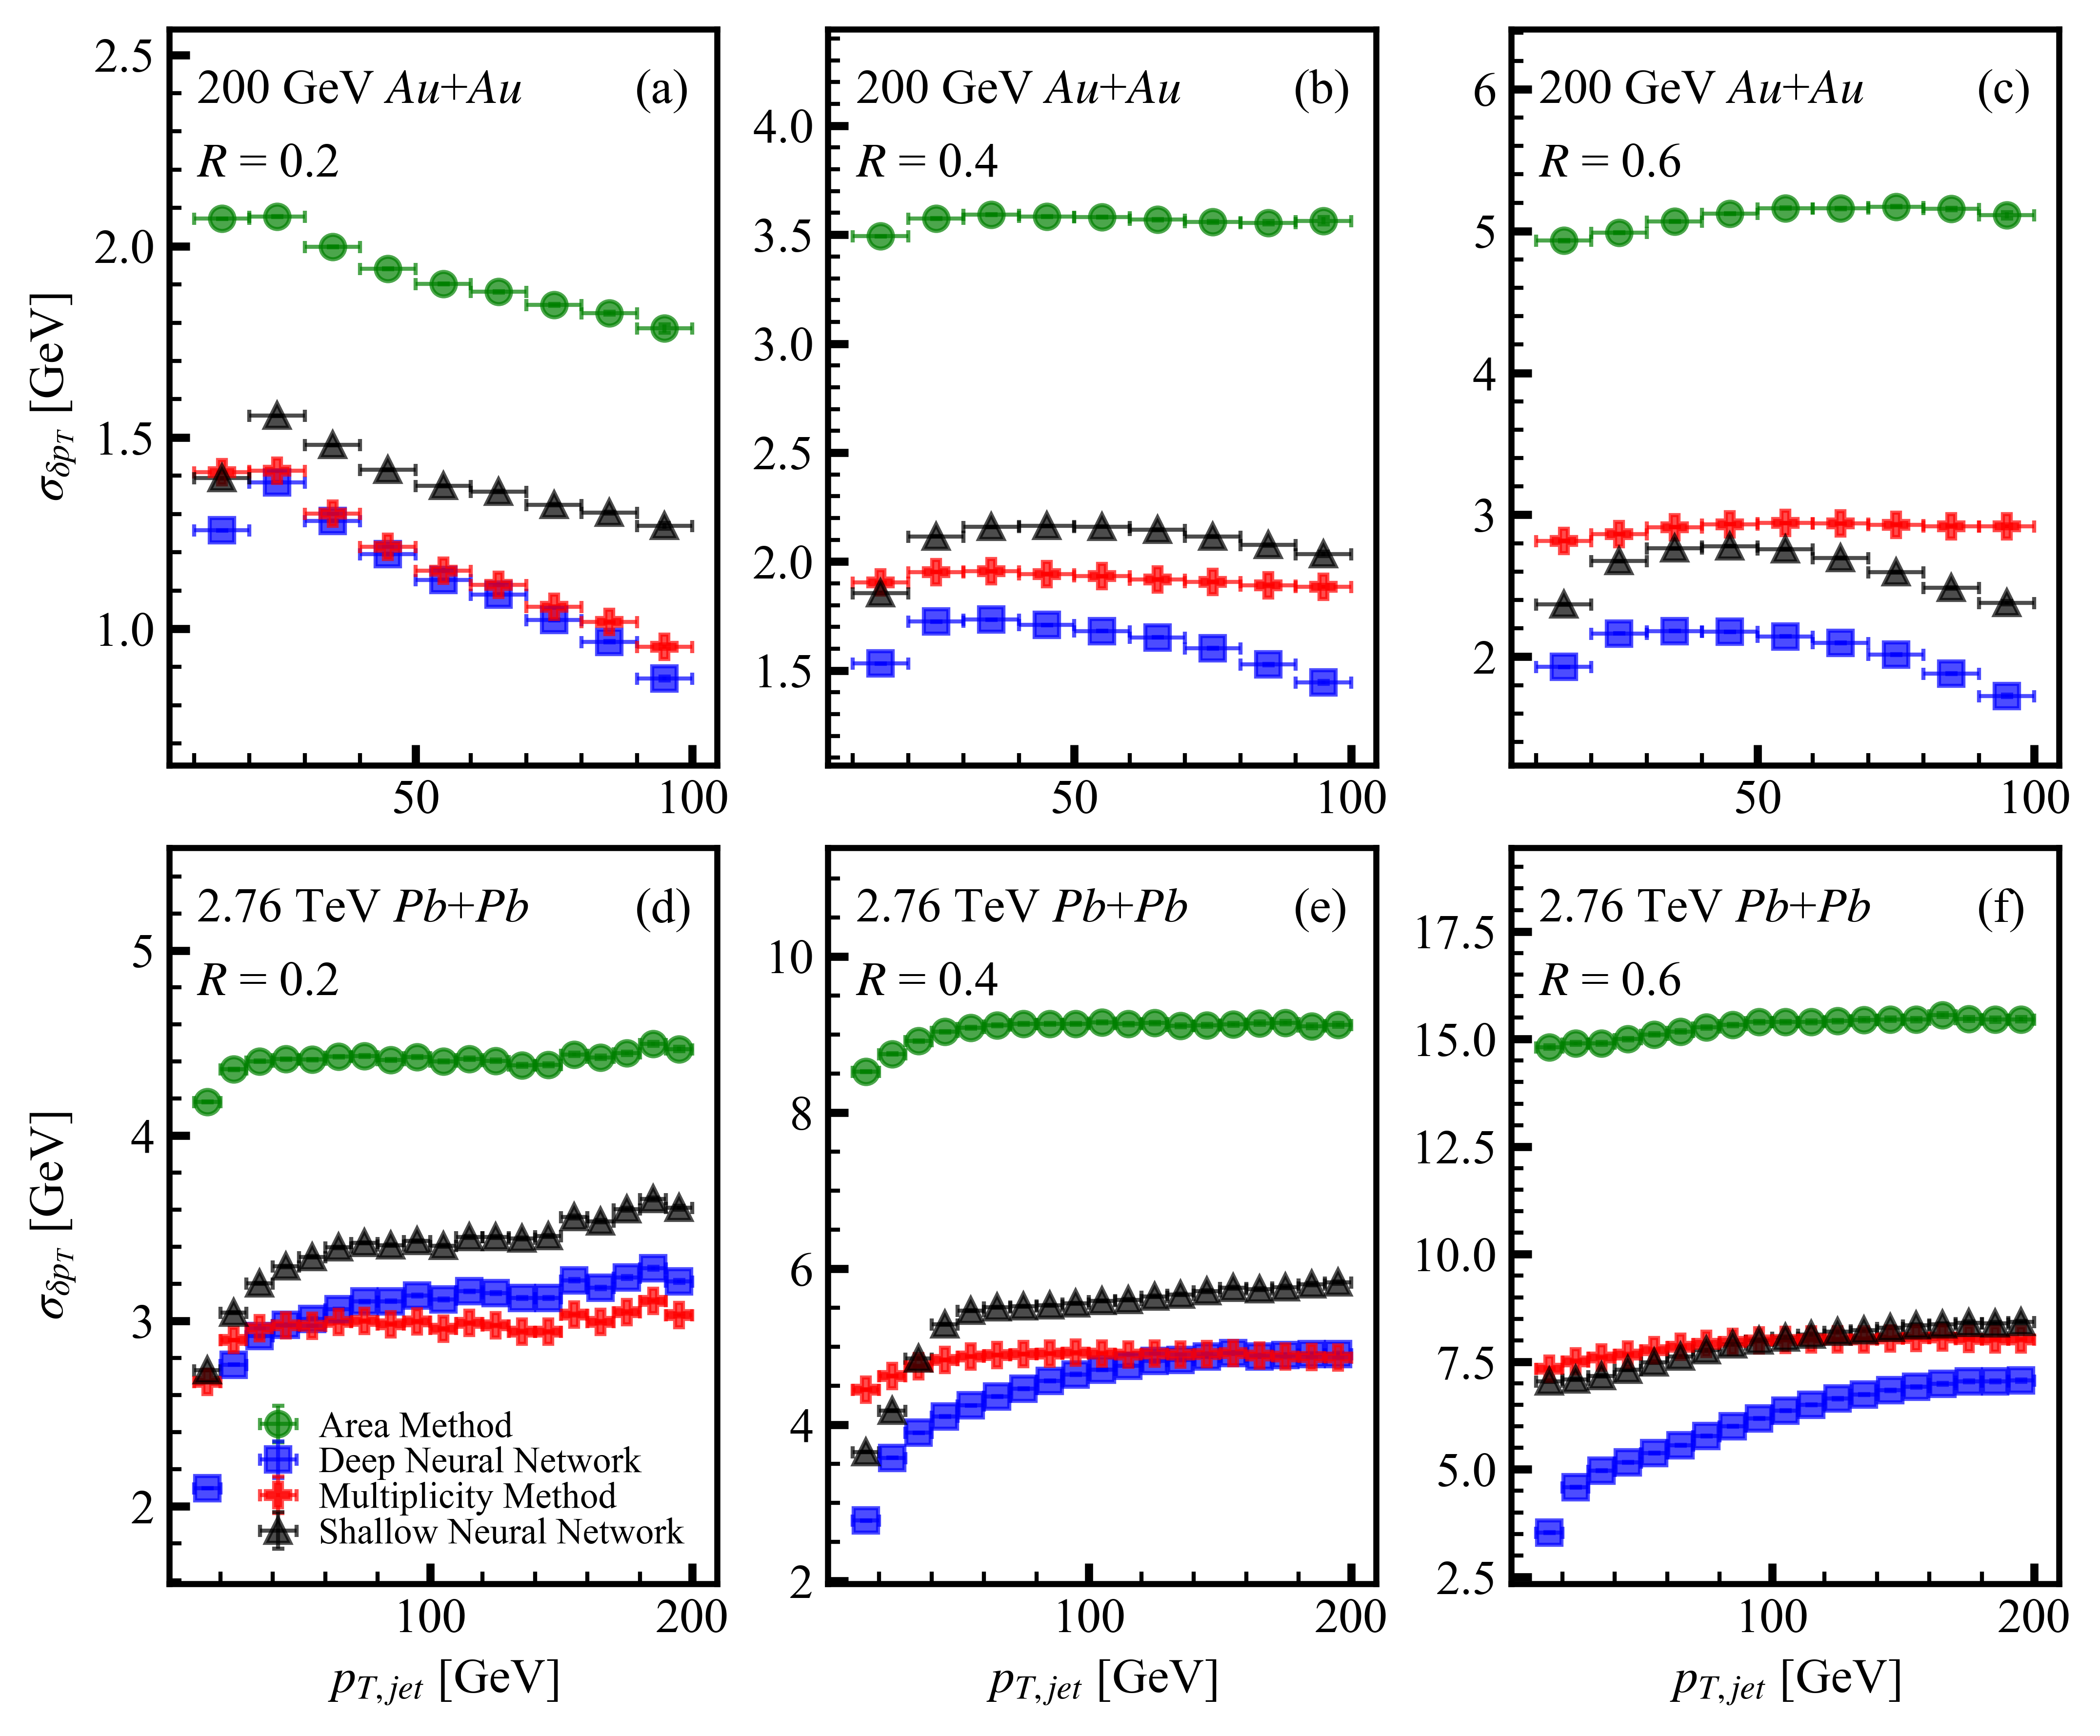

In [10]:
import paperstyle as ps
import matplotlib.pyplot as plt

fig_size = ps.GetFigSize(510.0, 1.5)
plt.rcParams.update(ps.style)
plt.rcParams.update({'figure.figsize': fig_size})

area_style = ps.area
dnn_style = ps.dnn
mult_style = ps.mult
snn_style = ps.snn

fig ,axs = plt.subplots(2, 3, dpi=600, constrained_layout=True)

datasets = ["AuAu_R02", "AuAu_R04", "AuAu_R06", "PbPb_R02", "PbPb_R04", "PbPb_R06"]
labels = [r'(a)', r'(b)', r'(c)', r'(d)', r'(e)', r'(f)']
species = [r'200 GeV $Au$+$Au$', r'200 GeV $Au$+$Au$', r'200 GeV $Au$+$Au$', r'2.76 TeV $Pb$+$Pb$', r'2.76 TeV $Pb$+$Pb$', r'2.76 TeV $Pb$+$Pb$']
radii = [r'$R$ = 0.2', r'$R$ = 0.4', r'$R$ = 0.6', r'$R$ = 0.2', r'$R$ = 0.4', r'$R$ = 0.6']
for i, dataset in enumerate(datasets):
    ax = axs[i//3, i%3]
    if i < 3:
        pass
        # ax.tick_params(labelbottom=False)
    else:
        ax.set_xlabel(r"$p_{T,jet}$ [GeV]")
        
    if i == 0 or i == 3:
        ax.set_ylabel(r"$\sigma_{\delta p_{T}}$ [GeV]")
    
    ax.errorbar(sigma[dataset]['x'], sigma[dataset]['area'], xerr=sigma[dataset]['x_err'], yerr=sigma[dataset]['area_err'], **area_style)
    ax.errorbar(sigma[dataset]['x'], sigma[dataset]['dnn'], xerr=sigma[dataset]['x_err'], yerr=sigma[dataset]['dnn_err'], **dnn_style)
    ax.errorbar(sigma[dataset]['x'], sigma[dataset]['nparts'], xerr=sigma[dataset]['x_err'], yerr=sigma[dataset]['nparts_err'], **mult_style)
    # ax.errorbar(sigma[dataset]['x'], sigma[dataset]['mult'], xerr=sigma[dataset]['x_err'], yerr=sigma[dataset]['mult_err'], **snn_style)
    ax.errorbar(sigma[dataset]['x'], sigma[dataset]['snn'], xerr=sigma[dataset]['x_err'], yerr=sigma[dataset]['snn_err'], **snn_style)
    ax.text(0.85, 0.9, labels[i], transform=ax.transAxes)
    ax.text(0.05, 0.9, species[i], transform=ax.transAxes)
    ax.text(0.05, 0.8, radii[i], transform=ax.transAxes)
    ax.set_ylim(ax.get_ylim()[0]*0.8, ax.get_ylim()[1]*1.2)
    
    if i == 3:
        ax.legend(loc='lower right', ncol=1, frameon=False, fontsize=9, labelspacing=0.05, handletextpad=0.1, columnspacing=0.1, markerscale=1.0)
    
fig.align_ylabels()
plt.show()
fig.savefig("pdf/MomentumResolution.pdf",  bbox_inches='tight')
fig.savefig("png/MomentumResolution.png",  bbox_inches='tight')       